# Predicting the Programming Languages of Most Starred Github Repos

## Goal
Build a model that can predict what programming language a repository is, given the text of the README file.

In [6]:
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

import os
import acquire
import prepare

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

## I. Acquire

Fetch data from local cache using the function `scrape_github_data` from the acquire.py module.

In [7]:
# acquire.scrape_github_data()

In [8]:
df = pd.read_json('final_data.json')

In [9]:
len(df)

676

In [10]:
df.head(1)

,language,readme_contents,repo
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",google-research/bert


## II. Prep

`prep_articles` function from the prepare.py module performs the following:
 - normalize data by removing non-ascii characters, special characters, numbers, white spaces...
 - tokenize words
 - stem and lemmatize words
 - remove stop words and other extraneous words

> We used the functions commented out below to generate a prepped data frame. Then we save the resulting data frame as a .json file.

In [11]:
# df = df[df.readme_contents.notnull()]
# df = prepare.prep_articles(df)
# df.to_json("prepped_df.json")

In [12]:
df = pd.read_json("prepped15_df.json")
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",bert new may whole wor...,bert new may whole word mask model thi releas ...,bert new may whole word masking model this rel...,bert new may whole word masking model release ...
10,Python,"<h1 align=""center""><img src=""https://cdn.rawgi...",align center img src https cdn rawgit co...,align center img src http cdn rawgit com jarun...,align center img src http cdn rawgit com jarun...,align center cdn rawgit jarun googler master g...
100,Ruby,![logo](http://i.imgur.com/i2fElxx.png)\n\n__`...,logo http imgur com felxx png xcpret...,logo http imgur com felxx png xcpretti fast an...,logo http imgur com felxx png xcpretty fast an...,imgur felxx xcpretty fast flexible formatter x...
101,Go,# JX \n\nJX is a command line tool for install...,command line tool for installing and using je...,command line tool for instal and use jenkin ht...,command line tool for installing and using jen...,command line tool installing using jenkins jen...
102,JavaScript,"<div align=""center""> \n<table>\n<colgroup>\n<c...",div align center table colgroup col w...,div align center tabl colgroup col width colgr...,div align center table colgroup col width colg...,align center table colgroup col width colgroup...


What are the words we want to exclude?
- http
- banner
- request
- img
- badge
- svg
- www
- com
- png
- welcome
- pr
- style
- flat
- makeapullrequest
- gitpod
- logo
- blue
- green
- brightgreen
- div
- align
- center
- width
- src

Look for documents where there are no programming language indicated.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 99
Data columns (total 6 columns):
language      504 non-null object
original      504 non-null object
normalized    504 non-null object
stemmed       504 non-null object
lemmatized    504 non-null object
cleaned       504 non-null object
dtypes: object(6)
memory usage: 27.6+ KB


In [14]:
df[df.language.isnull()]

,language,original,normalized,stemmed,lemmatized,cleaned


Since the programming language is necessary to train the model, we will drop these documents from our data set.

## III. Explore

Extract a separate data frame called `dfx` that will be used for exploration. We will only focus on the target variable `language` and the feature variable `cleaned` which contains the content of the readme files.

Below are the questions we want to answer in this phase:
1. What are the most common words in READMEs?
2. What does the distribution of IDFs look like for the most common words?
3. Does the length of the README vary by programming language?
4. Do different programming languages use a different number of unique words?

In [15]:
dfx = df[["language","cleaned"]]

In [16]:
dfx.head()

,language,cleaned
0,Python,bert new may whole word masking model release ...
10,Python,align center cdn rawgit jarun googler master g...
100,Ruby,imgur felxx xcpretty fast flexible formatter x...
101,Go,command line tool installing using jenkins jen...
102,JavaScript,align center table colgroup col width colgroup...


#### A. Distribution of Data, Top Words

In [17]:
value_counts = pd.DataFrame(dfx.language.value_counts(ascending=False))
value_counts

,language
JavaScript,129
Python,83
Java,47
PHP,40
Go,37
Jupyter Notebook,25
HTML,23
Swift,22
TypeScript,20
Ruby,18


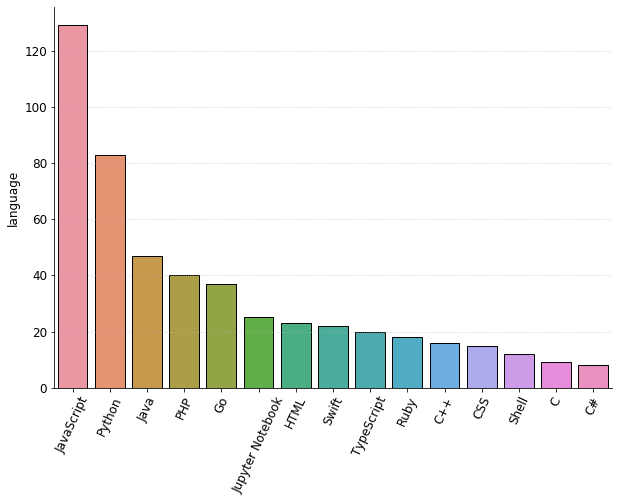

In [18]:
plt.figure(figsize=(10,7))
bar = sns.barplot(x=value_counts.index, y="language", data=value_counts)
bar.set_xticklabels(bar.get_xticklabels(),rotation=65)

plt.show()

#### Look at Lengths of README files by Language


In [19]:
df_len = dfx.assign(length = dfx.cleaned.apply(len))
df_len.head()

,language,cleaned,length
0,Python,bert new may whole word masking model release ...,28440
10,Python,align center cdn rawgit jarun googler master g...,14023
100,Ruby,imgur felxx xcpretty fast flexible formatter x...,2395
101,Go,command line tool installing using jenkins jen...,6025
102,JavaScript,align center table colgroup col width colgroup...,2694


In [20]:
# length of READMEs for JavaScript subset

df_len[df_len['language'] == 'JavaScript']['length'].sort_values(ascending=False)

183    140406
205     93273
13      57923
186     48400
120     48400
208     48333
215     42689
281     24971
63      14415
527     14415
57      14269
557     14082
97      13053
534     12839
391     12397
52      12307
43      11975
633     11889
5       10507
528     10193
67      10193
659      9487
638      8857
240      8666
560      7842
508      7682
437      7663
177      7531
661      7500
570      6921
        ...  
56       1283
66       1263
498      1260
472      1237
516      1212
407      1182
12       1022
484       945
16        938
524       931
382       791
31        727
398       723
523       700
492       696
425       694
344       655
35        625
671       595
504       547
6         540
510       506
211       488
440       460
486       411
221       184
213       170
233       122
17         87
234        50
Name: length, Length: 129, dtype: int64

In [21]:
# length of READMEs for Python subset

df_len[df_len['language'] == 'Python']['length'].sort_values(ascending=False)

247    61622
408    55581
181    55581
69     48936
258    48485
122    43543
652    39503
290    36639
241    31879
242    29457
0      28440
272    28440
291    23907
252    23439
273    22063
650    17498
2      16678
70     15196
10     14023
84     12147
410    12116
296    11675
497    11601
262    10520
243     9766
520     9647
467     9647
128     9462
413     8737
178     8054
       ...  
636     3670
533     3551
112     2976
179     2823
265     2401
19      2352
257     2236
289     2042
535     1986
309     1637
9       1544
481     1486
518     1414
283     1165
62      1162
660     1137
601     1044
466      993
98       966
29       924
462      754
74       672
507      593
280      513
230      419
304      173
478      142
515      120
613        4
522        0
Name: length, Length: 83, dtype: int64

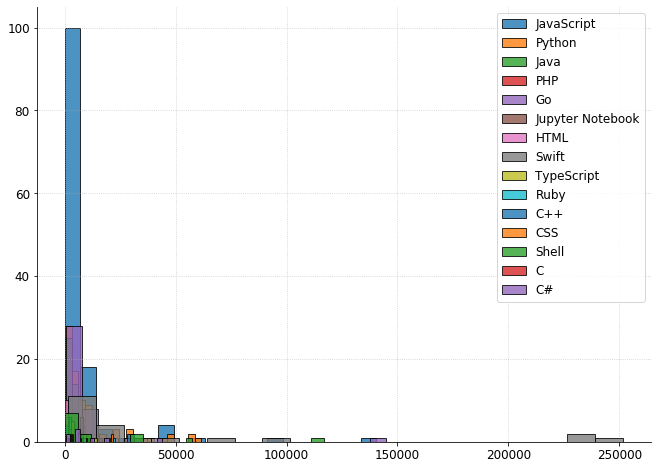

In [22]:
# README length by language

languages = ['JavaScript', 'Python', 'Java', 'PHP', 'Go', 'Jupyter Notebook', 
             'HTML', 'Swift', 'TypeScript', 'Ruby', 'C++', 'CSS', 'Shell',
             'C', 'C#']

bins = 20
for lang in languages:
    plt.hist(df_len[df_len['language'] == lang]['length'], bins=bins, alpha=0.8, label=lang)
    
plt.legend()
plt.show()

#### Value Counts and Percentages for Language

In [23]:
pd.concat(
    [dfx.language.value_counts(), dfx.language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
JavaScript,129,0.255952
Python,83,0.164683
Java,47,0.093254
PHP,40,0.079365
Go,37,0.073413
Jupyter Notebook,25,0.049603
HTML,23,0.045635
Swift,22,0.043651
TypeScript,20,0.039683
Ruby,18,0.035714


#### Term Frequency by Language

In [24]:
raw_count_js = pd.Series(' '.join(df[df.language=='JavaScript']['cleaned']).split()).value_counts()
raw_count_p = pd.Series(' '.join(df[df.language=='Python']['cleaned']).split()).value_counts()
raw_count_j = pd.Series(' '.join(df[df.language=='Java']['cleaned']).split()).value_counts()
raw_count_php = pd.Series(' '.join(df[df.language=='PHP']['cleaned']).split()).value_counts()
raw_count_go = pd.Series(' '.join(df[df.language=='Go']['cleaned']).split()).value_counts()
raw_count_jup = pd.Series(' '.join(df[df.language=='Jupyter Notebook']['cleaned']).split()).value_counts()
raw_count_html = pd.Series(' '.join(df[df.language=='HTML']['cleaned']).split()).value_counts()
raw_count_swift = pd.Series(' '.join(df[df.language=='Swift']['cleaned']).split()).value_counts()
raw_count_ts = pd.Series(' '.join(df[df.language=='TypeScript']['cleaned']).split()).value_counts()
raw_count_rub = pd.Series(' '.join(df[df.language=='Ruby']['cleaned']).split()).value_counts()
raw_count_cp = pd.Series(' '.join(df[df.language=='C++']['cleaned']).split()).value_counts()
raw_count_css = pd.Series(' '.join(df[df.language=='CSS']['cleaned']).split()).value_counts()
raw_count_shell = pd.Series(' '.join(df[df.language=='Shell']['cleaned']).split()).value_counts()
raw_count_c = pd.Series(' '.join(df[df.language=='C']['cleaned']).split()).value_counts()
raw_count_csharp = pd.Series(' '.join(df[df.language=='C#']['cleaned']).split()).value_counts()

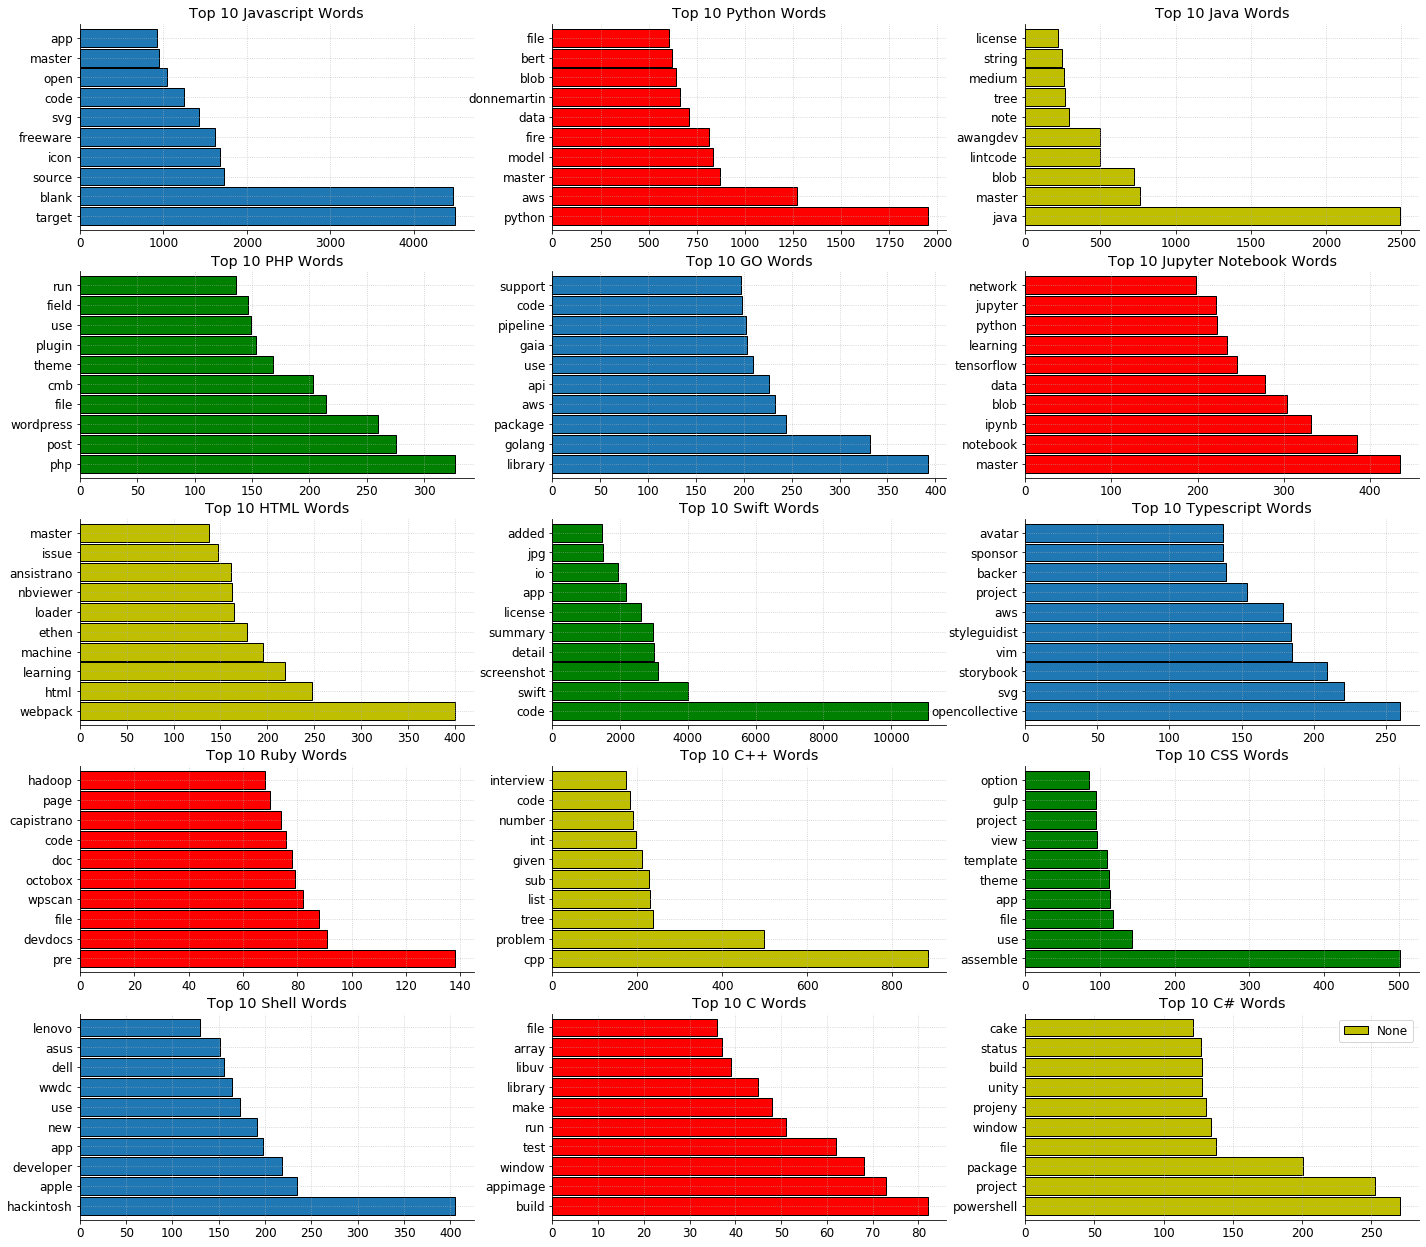

In [25]:
plt.figure(figsize=(24,22))

subplot(5,3,1)
raw_count_js.sort_values(ascending=False)[0:10].plot.barh(width=.9)
title('Top 10 Javascript Words')

subplot(5, 3, 2)
raw_count_p.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
title('Top 10 Python Words')

subplot(5, 3, 3)
raw_count_j.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
title('Top 10 Java Words')

subplot(5, 3, 4)
raw_count_php.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='g')
title('Top 10 PHP Words')


subplot(5, 3, 5)
raw_count_go.sort_values(ascending=False)[0:10].plot.barh(width=.9)
title('Top 10 GO Words')


subplot(5, 3, 6)
raw_count_jup.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
title('Top 10 Jupyter Notebook Words')


subplot(5, 3, 7)
raw_count_html.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
title('Top 10 HTML Words')


subplot(5, 3, 8)
raw_count_swift.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='g')
title('Top 10 Swift Words')


subplot(5, 3, 9)
raw_count_ts.sort_values(ascending=False)[0:10].plot.barh(width=.9)
title('Top 10 Typescript Words')

subplot(5, 3, 10)
raw_count_rub.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
title('Top 10 Ruby Words')


subplot(5, 3, 11)
raw_count_cp.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
title('Top 10 C++ Words')


subplot(5, 3, 12)
raw_count_css.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='g')
title('Top 10 CSS Words')


subplot(5, 3, 13)
raw_count_shell.sort_values(ascending=False)[0:10].plot.barh(width=.9)
title('Top 10 Shell Words')


subplot(5, 3, 14)
raw_count_c.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
title('Top 10 C Words')


subplot(5, 3, 15)
raw_count_csharp.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
title('Top 10 C# Words')

plt.legend()
plt.show()

#### Term Frequency Overall

In [26]:
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()

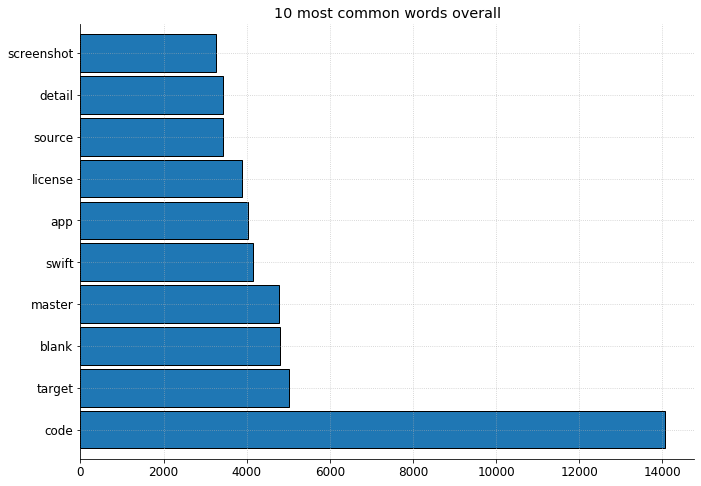

In [27]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words overall')

plt.show()

Make a variable named `corpus`, which is a pd.Series of all the words in `dfx`. Correspondingly, make a variable named `bag` (i.e., "bag of words") which provides us with a list of all words in one big collection.

In [44]:
corpus = pd.Series(" ".join(dfx.cleaned).split())
bag = " ".join(dfx.cleaned)

(-0.5, 399.5, 199.5, -0.5)

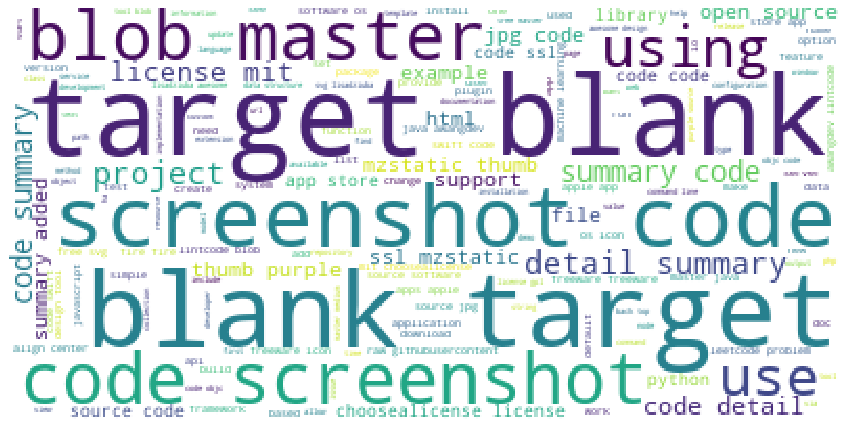

In [45]:
plt.figure(figsize=(15, 8))
img = WordCloud(background_color='white',random_state=1).generate(bag)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

#### C. Common Bigrams

## IV. Model

In [46]:
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",bert new may whole wor...,bert new may whole word mask model thi releas ...,bert new may whole word masking model this rel...,bert new may whole word masking model release ...
10,Python,"<h1 align=""center""><img src=""https://cdn.rawgi...",align center img src https cdn rawgit co...,align center img src http cdn rawgit com jarun...,align center img src http cdn rawgit com jarun...,align center cdn rawgit jarun googler master g...
100,Ruby,![logo](http://i.imgur.com/i2fElxx.png)\n\n__`...,logo http imgur com felxx png xcpret...,logo http imgur com felxx png xcpretti fast an...,logo http imgur com felxx png xcpretty fast an...,imgur felxx xcpretty fast flexible formatter x...
101,Go,# JX \n\nJX is a command line tool for install...,command line tool for installing and using je...,command line tool for instal and use jenkin ht...,command line tool for installing and using jen...,command line tool installing using jenkins jen...
102,JavaScript,"<div align=""center""> \n<table>\n<colgroup>\n<c...",div align center table colgroup col w...,div align center tabl colgroup col width colgr...,div align center table colgroup col width colg...,align center table colgroup col width colgroup...


### A. TFIDF

Get features using TFIDF

In [82]:
df

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",bert new may whole wor...,bert new may whole word mask model thi releas ...,bert new may whole word masking model this rel...,bert new may whole word masking model release ...
10,Python,"<h1 align=""center""><img src=""https://cdn.rawgi...",align center img src https cdn rawgit co...,align center img src http cdn rawgit com jarun...,align center img src http cdn rawgit com jarun...,align center cdn rawgit jarun googler master g...
100,Ruby,![logo](http://i.imgur.com/i2fElxx.png)\n\n__`...,logo http imgur com felxx png xcpret...,logo http imgur com felxx png xcpretti fast an...,logo http imgur com felxx png xcpretty fast an...,imgur felxx xcpretty fast flexible formatter x...
101,Go,# JX \n\nJX is a command line tool for install...,command line tool for installing and using je...,command line tool for instal and use jenkin ht...,command line tool for installing and using jen...,command line tool installing using jenkins jen...
102,JavaScript,"<div align=""center""> \n<table>\n<colgroup>\n<c...",div align center table colgroup col w...,div align center tabl colgroup col width colgr...,div align center table colgroup col width colg...,align center table colgroup col width colgroup...
103,Go,# CDS: Continuous Delivery Service\n\n[![Join ...,cds continuous delivery service join the ...,cd continu deliveri servic join the chat http ...,cd continuous delivery service join the chat h...,cd continuous delivery service join chat gitte...
104,PHP,PHPCI\n=====\n\nPHPCI is a free and open sourc...,phpci phpci free and open source bsd...,phpci phpci free and open sourc bsd licens con...,phpci phpci free and open source bsd license c...,phpci phpci free open source bsd license conti...
105,C#,﻿# Cake\n\n[![NuGet](https://img.shields.io/nu...,cake nuget https img shields nuget ca...,cake nuget http img shield nuget cake svg http...,cake nuget http img shield nuget cake svg http...,cake nuget shield nuget cake svg nuget package...
108,Ruby,# Hound\n\n[![Build Status](https://circleci.c...,hound build status https circleci com ...,hound build statu http circleci com houndci ho...,hound build status http circleci com houndci h...,hound build status circleci houndci hound svg ...
109,Go,"<p align=""center"">\n <img align=""center"" sr...",align center img align center src d...,align center img align center src doc asset im...,align center img align center src doc asset im...,align center align center doc asset blue svg w...


In [79]:
df_dict = dict(df.cleaned)

In [80]:
tfidf = TfidfVectorizer()
sparse = tfidf.fit_transform(df_dict.values())

In [74]:
sparse_matrix = pd.DataFrame(sparse.todense(),columns=tfidf.get_feature_names())

In [78]:
sparse_matrix.head()

,aaa,aaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaaj,aaafj,aaai,aab,aabac,...,zybuluo,zydeco,zydis,zypper,zysuper,zyszys,zythum,zythumbnailtableview,zzan,zzmark
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.006662,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### B. Split Train-Test

In [84]:
X = tfidf.fit_transform(df.cleaned)
y = df.language

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [89]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
